# Recommender Systems 2018/19

### Practice 9 - Collaborative Boosted FW


### Underlying idea... the way to capture the feature importance from the user point of view, is to... use its point of view (e.g., ratings, collaborative similarity)

## A few info about feature weightign techniques

* Information retrieval methods (TF-IDF, BM25..) do not optimize a predictive model
* Embedding methods (FISM, UFSM, Factorization Machines) optimize everything at the same time, model and weights, but are difficult to train and sensitive to noise
* Wrapper methods (LFW, CFW) apply a two step approach approximating an already built collaborative model, more robust and easier to tune


from urllib.request import urlretrieve
import zipfile

# skip the download
#urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", "data/Movielens_10M/movielens_10m.zip")
dataFile = zipfile.ZipFile("data/Movielens_10M/movielens_10m.zip")
URM_path = dataFile.extract("ml-10M100K/ratings.dat", path = "data/Movielens_10M")
URM_file = open(URM_path, 'r')


def rowSplit (rowString):
    
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = float(split[2])
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result


URM_file.seek(0)
URM_tuples = []

for line in URM_file:
   URM_tuples.append(rowSplit (line))

userList, itemList, ratingList, timestampList = zip(*URM_tuples)

userList = list(userList)
itemList = list(itemList)
ratingList = list(ratingList)
timestampList = list(timestampList)

import scipy.sparse as sps

URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all = URM_all.tocsr()



ICM_path = dataFile.extract("ml-10M100K/tags.dat", path = "data/Movielens_10M")
ICM_file = open(ICM_path, 'r')

def rowSplit (rowString):
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = str(split[2]) # tag is a string, not a float like the rating
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result

ICM_file.seek(0)
ICM_tuples = []

for line in ICM_file:
    ICM_tuples.append(rowSplit(line))
    
userList_icm, itemList_icm, tagList_icm, timestampList_icm = zip(*ICM_tuples)

userList_icm = list(userList_icm)
itemList_icm = list(itemList_icm)
tagList_icm = list(tagList_icm)
timestampList_icm = list(timestampList_icm)

userList_unique = list(set(userList_icm))
itemList_unique = list(set(itemList_icm))
tagList_unique = list(set(tagList_icm))

numUsers = len(userList_unique)
numItems = len(itemList_unique)
numTags = len(tagList_unique)


print ("Number of items\t {}, Number of users\t {}".format(numItems, numUsers))
print ("Number of tags\t {}, Number of item-tag tuples {}".format(numTags, len(tagList_icm)))

print("\nData example:")
print(userList_icm[0:10])
print(itemList_icm[0:10])
print(tagList_icm[0:10])


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(tagList_icm)

tagList_icm = le.transform(tagList_icm)

import numpy as np

ones = np.ones(len(tagList_icm))

ICM_all = sps.coo_matrix((ones, (itemList_icm, tagList_icm)), shape=(URM_all.shape[1], tagList_icm.max()+1))
ICM_all = ICM_all.tocsr()

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
%matplotlib inline
# import src.utils.build_icm as build_icm
import scipy.sparse as sps
from src.utils.data_splitter import train_test_holdout, train_test_user_holdout, train_test_row_holdout
# from src.utils.evaluation import evaluate_algorithm, evaluate_algorithm_recommendations
# from src.utils.top_n_idx_sparse import top_n_idx_sparse
# from src.utils.Compute_Similarity_Python import Compute_Similarity_Python
# from src.libs.similarity import cosine
# import src.utils.similarity_wrapper as sim
# import time
import src.utils.build_icm as build_icm

import sys
sys.path.append('src/libs/RecSys_Course_2018')

In [2]:

JUPYTER = False
sys.path.append('src/data/')

# #### Load data
if JUPYTER:
    # Jupyter
    tracks_csv_file = "../../../data/tracks.csv"
    interactions_csv_file = "../../../data/train.csv"
    playlist_id_csv_file = "../../../data/target_playlists.csv"
    sequential_csv_file = "../../../data/train_sequential.csv"
else:
    # PyCharm
    tracks_csv_file = "data/tracks.csv"
    interactions_csv_file = "data/train.csv"
    playlist_id_csv_file = "data/target_playlists.csv"
    sequential_csv_file = "data/train_sequential.csv"

tracks_df = pd.read_csv(tracks_csv_file)
interactions_df = pd.read_csv(interactions_csv_file)
playlist_id_df = pd.read_csv(playlist_id_csv_file)
train_sequential_df = pd.read_csv(sequential_csv_file)
userList = interactions_df["playlist_id"]
itemList = interactions_df["track_id"]
ratingList = np.ones(interactions_df.shape[0])
targetsList = playlist_id_df["playlist_id"]
targetsListOrdered = targetsList[:5000].tolist()
targetsListCasual = targetsList[5000:].tolist()
userList_unique = pd.unique(userList)
itemList_unique = tracks_df["track_id"]
numUsers = len(userList_unique)
numItems = len(itemList_unique)
numberInteractions = interactions_df.size

# #### Build URM

URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all_csr = URM_all.tocsr()

# #### Train/test split: ratings and user holdout


In [25]:
ICM_all = build_icm.build_icm(tracks_df, split_duration_lenght=800, feature_weights={'albums': 1, 'artists': 0.5, 'durations': 0.1})
ICM_all = ICM_all.tocsr()

In [3]:
seed = 0
# ratings holdout
# URM_train, URM_test_pred = train_test_holdout(URM_all, train_perc=0.8, seed=seed)
# URM_test_known = None

# user holdout
# URM_train, URM_test_known, URM_test_pred = train_test_user_holdout(URM_all, user_perc=0.8, train_perc=0.8, seed=seed)

# row holdout
URM_train, URM_test_pred = train_test_row_holdout(URM_all, userList_unique, train_sequential_df, train_perc=0.8, seed=seed, targetsListOrdered=targetsListOrdered, nnz_threshold=10)
URM_test_known = None

# row holdout - validation
# URM_train_val, URM_test_pred = train_test_row_holdout(URM_all, userList_unique, train_sequential_df, train_perc=0.8,
#                                                       seed=seed, targetsListOrdered=targetsListOrdered,
#                                                       nnz_threshold=10)
# URM_train, URM_valid = train_test_holdout(URM_train_val, train_perc=0.7, seed=seed)
# URM_test_known = None

URM_train = URM_train
# URM_validation = URM_valid
URM_test = URM_test_pred

In [10]:
best_params_ItemKNNCF = {'topK': 700, 'shrink': 200, 'similarity': 'cosine', 'normalize': True}
best_params_ItemKNNCBF = {'topK': 500, 'shrink': 1000, 'similarity': 'cosine', 'normalize': True}

### Step 1: Create the two models, collaborative and content based

In [11]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender


itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit(**best_params_ItemKNNCF)

itemKNNCBF = ItemKNNCBFRecommender(ICM_all, URM_train)
itemKNNCBF.fit(**best_params_ItemKNNCBF)

Similarity column 20635 ( 100 % ), 1267.84 column/sec, elapsed time 0.27 min


Similarity column 20635 ( 100 % ), 832.19 column/sec, elapsed time 0.41 min


### Question, how the two similarities differ?

In [12]:
W_sparse_CF = itemKNNCF.W_sparse
W_sparse_CBF = itemKNNCBF.W_sparse

## Let's plt the global similarity distribution 

In [13]:
W_sparse_CF_sorted = np.sort(W_sparse_CF.data.copy())
W_sparse_CBF_sorted = np.sort(W_sparse_CBF.data.copy())

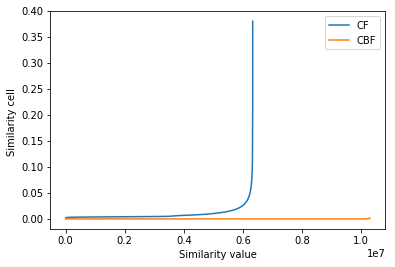

In [16]:
import numpy as np
import matplotlib.pyplot as pyplot


pyplot.plot(W_sparse_CF_sorted, label = 'CF')
pyplot.plot(W_sparse_CBF_sorted, label = 'CBF')
pyplot.ylabel('Similarity cell ')
pyplot.xlabel('Similarity value')
pyplot.legend()
pyplot.show()

## Let's now plot the delta for the common values

In [17]:
# Get common structure
W_sparse_CF_structure = W_sparse_CF.copy()
W_sparse_CF_structure.data = np.ones_like(W_sparse_CF_structure.data)

W_sparse_CBF_structure = W_sparse_CBF.copy()
W_sparse_CBF_structure.data = np.ones_like(W_sparse_CBF_structure.data)

W_sparse_common = W_sparse_CF_structure.multiply(W_sparse_CBF_structure)

# Get values of both in common structure of CF
W_sparse_delta = W_sparse_CBF.copy().multiply(W_sparse_common)
W_sparse_delta -= W_sparse_CF.copy().multiply(W_sparse_common)

In [18]:
W_sparse_delta_sorted = np.sort(W_sparse_delta.data.copy())

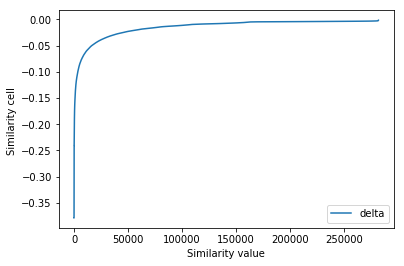

In [19]:
pyplot.plot(W_sparse_delta_sorted, label = 'delta')
pyplot.ylabel('Similarity cell ')
pyplot.xlabel('Similarity value')
pyplot.legend()
pyplot.show()

In [20]:
# How many values we have in common?

print("W_sparse_CF has {:.2E} values and {:.2f} % in common with CBF".format(W_sparse_CF.nnz, W_sparse_common.nnz/W_sparse_CF.nnz*100))
print("W_sparse_CBF has {:.2E} values and {:.2f} % in common with CF".format(W_sparse_CBF.nnz, W_sparse_common.nnz/W_sparse_CBF.nnz*100))

print("W_sparse_delta has {:.2E} values".format(W_sparse_delta.nnz))


W_sparse_CF has 6.33E+06 values and 4.45 % in common with CBF
W_sparse_CBF has 1.03E+07 values and 2.74 % in common with CF
W_sparse_delta has 2.82E+05 values


## What do we see?
## The great majority of similarities are not common... the models are modeling two very different phenomena

# Idea: 

## what if we were to weight features in such a way to approximate as well as possible the collaborative similarity?

### Basic model:  $S_{CBF} = ICM \cdot diag(feature\_weights) \cdot ICM^{T}$ 


### We want  $S_{CBF} = S_{CF}$

### Hence we wish to find the weights such that  $S_{CF} = ICM \cdot diag(feature\_weights) \cdot ICM^{T}$ 

### Now, we can rearrange the equations considering that we need only weights for features the two items have in common... this becomes a regression problem in form Ax = b. In our case A are the common features, x the weights and b the collaborative similarity


### Since it is a regression problem, we can use an already available solver like linalg in scipy.sparse

### It takes as imput two data structures, one is sparse and the other is the target value

In [21]:
W_sparse_delta = W_sparse_delta.tocoo()


item_index_1 = W_sparse_delta.row[666]
item_index_2 = W_sparse_delta.col[666]

In [22]:
print("Item indices are {} and {}".format(item_index_1, item_index_2))

Item indices are 93 and 16630


In [23]:
print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))

Collaborative similarity value is 0.016511112451553345
Content-based similarity value is 0.00025967281544581056


### Compute the common features

In [26]:
common_features = ICM_all[item_index_1,:].multiply(ICM_all[item_index_2,:])
common_features

<1x19416 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [27]:
common_features.indices

array([16526, 19412], dtype=int32)

## These items have just a common feature, that is a common scenario

### Let's look for items having  a few features in common, say 5

In [29]:
min_common_features = 5

for inner_index in range(len(W_sparse_delta.row)):

    item_index_1 = W_sparse_delta.row[inner_index]
    item_index_2 = W_sparse_delta.col[inner_index]

    common_features = ICM_all[item_index_1,:].multiply(ICM_all[item_index_2,:])
    
    if common_features.nnz >= min_common_features:
        
        # Bad programming, don't do this at home
        break
        
        

print("Item indices are {} and {}".format(item_index_1, item_index_2))

print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))
    
common_features.indices


KeyboardInterrupt: 

In [ ]:
from scipy.sparse import linalg

loss_tolerance = 1e-6
iteration_limit = 50000
damp_coeff=0.0

W_sparse_CF_value = W_sparse_CF[item_index_1, item_index_2]

In [20]:
linalg_result = linalg.lsqr(common_features, W_sparse_CF_value, show = False, atol=loss_tolerance, btol=loss_tolerance,
                  iter_lim = iteration_limit, damp=damp_coeff)

In [21]:
feature_weights = linalg_result[0].copy()
feature_weights

array([0., 0., 0., ..., 0., 0., 0.])

In [22]:
feature_weights[common_features.indices]

array([0.01156237, 0.01156237, 0.01156237, 0.02312475, 0.01156237,
       0.01156237])

### Note that all weights will be zeros except for the features those items have in common, nothing can be learned if a feature is not common

### If a dataset has a very sparse ICM, this FW method will struggle

In [23]:
new_CBF_value = common_features.dot(feature_weights)
new_CBF_value

array([0.10406136])

In [24]:
print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))

print("Weighted Content-based similarity value is {}".format(new_CBF_value[0]))

Collaborative similarity value is 0.10406135022640228
Content-based similarity value is 0.003887253813445568
Weighted Content-based similarity value is 0.10406135642893984


### Note that we learned the CF similarity amost exactly...

### Warning: 5 common features and 1 similarity value, more parameters than data points, overfitting!

### if we want to apply this method to the whole dataset we have to compute the common features of all items having a common similarity value. Whe already know who they are, thanks to W_sparse_delta

In [25]:
from FW_Similarity.CFW_D_Similarity_Linalg import CFW_D_Similarity_Linalg

In [26]:
CFW_weithing = CFW_D_Similarity_Linalg(URM_train, ICM_all, W_sparse_CF)
CFW_weithing.fit()

CFW_D_Similarity_Linalg: Generating train data
Similarity column 65134 ( 100 % ), 7078.34 column/sec, elapsed time 0.15 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.65E-03, nonzero cells 6997140
CFW_D_Similarity_Linalg: Content S density: 3.72E-04, nonzero cells 1576400
CFW_D_Similarity_Linalg: Content S structure has 391759 out of 1576400 ( 24.85%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 2.15E+04, average is: 5.48E-02, average over all collaborative data is 3.96E-02
Similarity column 65134 ( 100 % ), 8529.33 column/sec, elapsed time 0.13 min


In [27]:
from Base.Evaluation.Evaluator import SequentialEvaluator

evaluator_validation = SequentialEvaluator(URM_validation, cutoff_list=[5])
evaluator_test = SequentialEvaluator(URM_test, cutoff_list=[5])


In [28]:
results_dict, _ = evaluator_test.evaluateRecommender(itemKNNCF)
results_dict

SequentialEvaluator: Processed 26001 ( 37.21% ) in 30.60 seconds. Users per second: 850
SequentialEvaluator: Processed 52001 ( 74.42% ) in 60.66 seconds. Users per second: 857
SequentialEvaluator: Processed 69878 ( 100.00% ) in 81.15 seconds. Users per second: 861


{5: {'ROC_AUC': 0.46723098352366405,
  'PRECISION': 0.40995806977879595,
  'RECALL': 0.059623645438717045,
  'RECALL_TEST_LEN': 0.40995806977879595,
  'MAP': 0.30793995725884493,
  'MRR': 0.6000567656010045,
  'NDCG': 0.1135277274681038,
  'F1': 0.10410624521829824,
  'HIT_RATE': 2.049743839262715,
  'ARHR': 0.9715525630383403,
  'NOVELTY': 0.0007023937818802227,
  'DIVERSITY_MEAN_INTER_LIST': 0.9220336309252454,
  'DIVERSITY_HERFINDAHL': 0.9844040872038793,
  'COVERAGE_ITEM': 0.035726348757945156,
  'COVERAGE_USER': 0.9763860943438408,
  'DIVERSITY_GINI': 0.0540019674938619,
  'SHANNON_ENTROPY': 7.006445672447929}}

In [29]:
results_dict, _ = evaluator_test.evaluateRecommender(itemKNNCBF)
results_dict

SequentialEvaluator: Processed 26001 ( 37.21% ) in 30.10 seconds. Users per second: 864
SequentialEvaluator: Processed 53001 ( 75.85% ) in 60.49 seconds. Users per second: 876
SequentialEvaluator: Processed 69878 ( 100.00% ) in 78.78 seconds. Users per second: 887


{5: {'ROC_AUC': 0.33440901762118674,
  'PRECISION': 0.221171899596479,
  'RECALL': 0.02137001207891867,
  'RECALL_TEST_LEN': 0.221171899596479,
  'MAP': 0.15930526536728765,
  'MRR': 0.385309634887465,
  'NDCG': 0.055044632085446535,
  'F1': 0.03897426332006249,
  'HIT_RATE': 1.105855920318269,
  'ARHR': 0.5537696652260307,
  'NOVELTY': 0.0007347088404746575,
  'DIVERSITY_MEAN_INTER_LIST': 0.9083227620976749,
  'DIVERSITY_HERFINDAHL': 0.9816619526806698,
  'COVERAGE_ITEM': 0.013479902969263364,
  'COVERAGE_USER': 0.9763860943438408,
  'DIVERSITY_GINI': 0.09513240059116847,
  'SHANNON_ENTROPY': 6.665459802838011}}

In [30]:
results_dict, _ = evaluator_test.evaluateRecommender(CFW_weithing)
results_dict

SequentialEvaluator: Processed 27001 ( 38.64% ) in 30.63 seconds. Users per second: 882
SequentialEvaluator: Processed 56174 ( 80.39% ) in 60.63 seconds. Users per second: 926
SequentialEvaluator: Processed 69878 ( 100.00% ) in 74.20 seconds. Users per second: 942


{5: {'ROC_AUC': 0.32452989495978735,
  'PRECISION': 0.23120724691609873,
  'RECALL': 0.02304951439160784,
  'RECALL_TEST_LEN': 0.23120724691609873,
  'MAP': 0.15921238921170636,
  'MRR': 0.3820169915185444,
  'NDCG': 0.05800978544747865,
  'F1': 0.041919945316908395,
  'HIT_RATE': 1.1560290792524113,
  'ARHR': 0.5512860509268199,
  'NOVELTY': 0.0007110862032000976,
  'DIVERSITY_MEAN_INTER_LIST': 0.8111835999424309,
  'DIVERSITY_HERFINDAHL': 0.9622343982746422,
  'COVERAGE_ITEM': 0.02289127030429576,
  'COVERAGE_USER': 0.9763860943438408,
  'DIVERSITY_GINI': 0.045328940588679756,
  'SHANNON_ENTROPY': 5.884943926902329}}

### This algorithm has parameters too:
* topK, the usual number of neighbors
* add_zeros_quota, the percentage of zero collaborative similarities to add to the train set, this helps the regressor in finding non-relevant features
* normalize_similarity, apply or not the usual cosine denominator

In [32]:
from ParameterTuning.BayesianSearch import BayesianSearch
from ParameterTuning.AbstractClassSearch import DictionaryKeys

from ParameterTuning.AbstractClassSearch import EvaluatorWrapper


evaluator_validation_tuning = EvaluatorWrapper(evaluator_validation)
evaluator_test_tuning = EvaluatorWrapper(evaluator_test)


recommender_class = CFW_D_Similarity_Linalg

parameterSearch = BayesianSearch(recommender_class,
                                 evaluator_validation=evaluator_validation_tuning,
                                 evaluator_test=evaluator_test_tuning)


hyperparamethers_range_dictionary = {}
hyperparamethers_range_dictionary["topK"] = [5, 10, 20, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800]
hyperparamethers_range_dictionary["add_zeros_quota"] = range(0,1)
hyperparamethers_range_dictionary["normalize_similarity"] = [True, False]



recommenderDictionary = {DictionaryKeys.CONSTRUCTOR_POSITIONAL_ARGS: [URM_train, ICM_all, W_sparse_CF],
                         DictionaryKeys.CONSTRUCTOR_KEYWORD_ARGS: {},
                         DictionaryKeys.FIT_POSITIONAL_ARGS: dict(),
                         DictionaryKeys.FIT_KEYWORD_ARGS: dict(),
                         DictionaryKeys.FIT_RANGE_KEYWORD_ARGS: hyperparamethers_range_dictionary}

output_root_path = "result_experiments/"

import os

# If directory does not exist, create
if not os.path.exists(output_root_path):
    os.makedirs(output_root_path)

output_root_path += recommender_class.RECOMMENDER_NAME    
    
    
n_cases = 2
metric_to_optimize = "MAP"

best_parameters_CFW_D = parameterSearch.search(recommenderDictionary,
                                                 n_cases = n_cases,
                                                 output_root_path = output_root_path,
                                                 metric=metric_to_optimize)




Initialization
--------------------------------------------------------------------------------------
 Step |   Time |      Value |   add_zeros_quota |   normalize_similarity |      topK | 
BayesianSearch: Testing config: {'topK': 100, 'add_zeros_quota': 0.554339736755939, 'normalize_similarity': False}
CFW_D_Similarity_Linalg: Generating train data
Similarity column 65134 ( 100 % ), 8015.05 column/sec, elapsed time 0.14 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.65E-03, nonzero cells 6997140
CFW_D_Similarity_Linalg: Content S density: 1.47E-04, nonzero cells 624111
CFW_D_Similarity_Linalg: Content S structure has 176941 out of 624111 ( 28.35%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 9.84E+03, average is: 5.56E-02, average over all collaborative data is 3.96E-02
Similarity column 65134 ( 100 % ), 8082.12 column/sec, elapsed time 0.13 min
SequentialEvaluator: Processed 30248 ( 43.30% ) in 30.00 seconds. Users per second: 1008


Similarity column 65134 ( 100 % ), 8167.18 column/sec, elapsed time 0.13 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.65E-03, nonzero cells 6997140
CFW_D_Similarity_Linalg: Content S density: 7.86E-05, nonzero cells 333650
CFW_D_Similarity_Linalg: Content S structure has 102067 out of 333650 ( 30.59%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 5.75E+03, average is: 5.63E-02, average over all collaborative data is 3.96E-02
Similarity column 65134 ( 100 % ), 8763.21 column/sec, elapsed time 0.12 min
SequentialEvaluator: Processed 34817 ( 49.84% ) in 30.00 seconds. Users per second: 1161
SequentialEvaluator: Processed 69857 ( 100.00% ) in 59.88 seconds. Users per second: 1167
BayesianSearch: New best config found. Config: {'topK': 50, 'add_zeros_quota': 0.8760636327595164, 'normalize_similarity': False, 'epochs': 0, 'max_epochs': 0} - results: {'ROC_AUC': 0.23544049510667026, 'PRECISION': 0.12604200962916262, 'RECALL': 0.026032438217

### The best solution has a MAP of 0.1756062, slightly better than the pure CBF

### Let's try another ICM, the genres of the movie

In [33]:
genres_path = dataFile.extract("ml-10M100K/movies.dat", path = "data/Movielens_10M")


def _loadICM_genres(genres_path, header=True, separator='::', genresSeparator="|"):

    # Genres
    from data.IncrementalSparseMatrix import IncrementalSparseMatrix

    ICM_builder = IncrementalSparseMatrix(auto_create_col_mapper = True, 
                                          auto_create_row_mapper = False)


    fileHandle = open(genres_path, "r", encoding="latin1")
    numCells = 0

    if header:
        fileHandle.readline()

    for line in fileHandle:
        numCells += 1
        if (numCells % 1000000 == 0):
            print("Processed {} cells".format(numCells))

        if (len(line)) > 1:
            line = line.split(separator)

            line[-1] = line[-1].replace("\n", "")

            movie_id = int(line[0])

            title = line[1]
            # In case the title contains commas, it is enclosed in "..."
            # genre list will always be the last element
            genreList = line[-1]

            genreList = genreList.split(genresSeparator)

            # Rows movie ID
            # Cols features
            ICM_builder.add_single_row(movie_id, genreList, data = 1.0)


    fileHandle.close()

    return ICM_builder.get_SparseMatrix(), ICM_builder.get_column_token_to_id_mapper(), ICM_builder.get_row_token_to_id_mapper()


ICM_genres, _, _ = _loadICM_genres(genres_path, header=True, separator='::', genresSeparator="|")
ICM_genres = ICM_genres.tocsr()

ICM_genres

<65134x20 sparse matrix of type '<class 'numpy.float64'>'
	with 21559 stored elements in Compressed Sparse Row format>

In [34]:
CFW_weithing_genre = CFW_D_Similarity_Linalg(URM_train, ICM_genres, W_sparse_CF)
CFW_weithing_genre.fit()

results_dict, _ = evaluator_test.evaluateRecommender(CFW_weithing_genre)
results_dict

CFW_D_Similarity_Linalg: Generating train data
Similarity column 65134 ( 100 % ), 7304.08 column/sec, elapsed time 0.15 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.65E-03, nonzero cells 6997140
CFW_D_Similarity_Linalg: Content S density: 7.54E-04, nonzero cells 3199152
CFW_D_Similarity_Linalg: Content S structure has 343180 out of 3199152 ( 10.73%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.52E+04, average is: 4.43E-02, average over all collaborative data is 3.96E-02
Similarity column 65134 ( 100 % ), 7440.28 column/sec, elapsed time 0.15 min
SequentialEvaluator: Processed 33001 ( 47.23% ) in 30.22 seconds. Users per second: 1092
SequentialEvaluator: Processed 67001 ( 95.88% ) in 60.71 seconds. Users per second: 1104
SequentialEvaluator: Processed 69878 ( 100.00% ) in 62.66 seconds. Users per second: 1115


{5: {'ROC_AUC': 0.062148792657679544,
  'PRECISION': 0.032264804373338514,
  'RECALL': 0.002480477801986029,
  'RECALL_TEST_LEN': 0.032264804373338514,
  'MAP': 0.01579891620634061,
  'MRR': 0.06194820496675068,
  'NDCG': 0.004418842092226786,
  'F1': 0.004606791254688688,
  'HIT_RATE': 0.16132402186668193,
  'ARHR': 0.06979759962601224,
  'NOVELTY': 0.00105580196102687,
  'DIVERSITY_MEAN_INTER_LIST': 0.9819069472755356,
  'DIVERSITY_HERFINDAHL': 0.9963785791086539,
  'COVERAGE_ITEM': 0.07697976479258145,
  'COVERAGE_USER': 0.9763860943438408,
  'DIVERSITY_GINI': 0.12912814834069017,
  'SHANNON_ENTROPY': 9.410897424148793}}

In [35]:
from ParameterTuning.BayesianSearch import BayesianSearch
from ParameterTuning.AbstractClassSearch import DictionaryKeys

from ParameterTuning.AbstractClassSearch import EvaluatorWrapper


evaluator_validation_tuning = EvaluatorWrapper(evaluator_validation)
evaluator_test_tuning = EvaluatorWrapper(evaluator_test)


recommender_class = CFW_D_Similarity_Linalg

parameterSearch = BayesianSearch(recommender_class,
                                 evaluator_validation=evaluator_validation_tuning,
                                 evaluator_test=evaluator_test_tuning)


hyperparamethers_range_dictionary = {}
hyperparamethers_range_dictionary["topK"] = [5, 10, 20, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800]
hyperparamethers_range_dictionary["add_zeros_quota"] = range(0,1)
hyperparamethers_range_dictionary["normalize_similarity"] = [True, False]



recommenderDictionary = {DictionaryKeys.CONSTRUCTOR_POSITIONAL_ARGS: [URM_train, ICM_genres, W_sparse_CF],
                         DictionaryKeys.CONSTRUCTOR_KEYWORD_ARGS: {},
                         DictionaryKeys.FIT_POSITIONAL_ARGS: dict(),
                         DictionaryKeys.FIT_KEYWORD_ARGS: dict(),
                         DictionaryKeys.FIT_RANGE_KEYWORD_ARGS: hyperparamethers_range_dictionary}


output_root_path = "result_experiments/ICM_genres/"

import os

# If directory does not exist, create
if not os.path.exists(output_root_path):
    os.makedirs(output_root_path)

    
output_root_path += recommender_class.RECOMMENDER_NAME      
    
n_cases = 2
metric_to_optimize = "MAP"

best_parameters_CFW_D = parameterSearch.search(recommenderDictionary,
                                                 n_cases = n_cases,
                                                 output_root_path = output_root_path,
                                                 metric=metric_to_optimize)


Initialization
--------------------------------------------------------------------------------------
 Step |   Time |      Value |   add_zeros_quota |   normalize_similarity |      topK | 
BayesianSearch: Testing config: {'topK': 50, 'add_zeros_quota': 0.5460399111630392, 'normalize_similarity': False}
CFW_D_Similarity_Linalg: Generating train data
Similarity column 65134 ( 100 % ), 7442.35 column/sec, elapsed time 0.15 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.65E-03, nonzero cells 6997140
CFW_D_Similarity_Linalg: Content S density: 1.26E-04, nonzero cells 533928
CFW_D_Similarity_Linalg: Content S structure has 65514 out of 533928 ( 12.27%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 3.02E+03, average is: 4.60E-02, average over all collaborative data is 3.96E-02
Similarity column 65134 ( 100 % ), 7324.09 column/sec, elapsed time 0.15 min
SequentialEvaluator: Processed 38948 ( 55.75% ) in 30.00 seconds. Users per second: 1298
S

Similarity column 65134 ( 100 % ), 7459.88 column/sec, elapsed time 0.15 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.65E-03, nonzero cells 6997140
CFW_D_Similarity_Linalg: Content S density: 1.26E-05, nonzero cells 53395
CFW_D_Similarity_Linalg: Content S structure has 6812 out of 53395 ( 12.76%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 3.17E+02, average is: 4.66E-02, average over all collaborative data is 3.96E-02
Similarity column 65134 ( 100 % ), 7629.74 column/sec, elapsed time 0.14 min
SequentialEvaluator: Processed 45001 ( 64.42% ) in 30.34 seconds. Users per second: 1483
SequentialEvaluator: Processed 69857 ( 100.00% ) in 46.54 seconds. Users per second: 1501
BayesianSearch: Config is suboptimal. Config: {'topK': 5, 'add_zeros_quota': 0.35747392814147605, 'normalize_similarity': False, 'epochs': 0, 'max_epochs': 0} - results: {'ROC_AUC': 0.03925399983776381, 'PRECISION': 0.016944376846034545, 'RECALL': 0.0023314664826787

/home/maurizio/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Bayesian Optimization
--------------------------------------------------------------------------------------
 Step |   Time |      Value |   add_zeros_quota |   normalize_similarity |      topK | 
BayesianSearch: Testing config: {'topK': 200, 'add_zeros_quota': 0.0008248131146192383, 'normalize_similarity': False}
CFW_D_Similarity_Linalg: Generating train data
Similarity column 65134 ( 100 % ), 7253.56 column/sec, elapsed time 0.15 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.65E-03, nonzero cells 6997140
CFW_D_Similarity_Linalg: Content S density: 5.03E-04, nonzero cells 2134992
CFW_D_Similarity_Linalg: Content S structure has 237124 out of 2134992 ( 11.11%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.06E+04, average is: 4.48E-02, average over all collaborative data is 3.96E-02
Similarity column 65134 ( 100 % ), 7353.67 column/sec, elapsed time 0.15 min
SequentialEvaluator: Processed 35001 ( 50.10% ) in 30.12 seconds. Users per 

/home/maurizio/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.3431562e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/home/maurizio/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.17750328e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/home/maurizio/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


BayesianSearch: Best config is: Config {'topK': 50, 'add_zeros_quota': 0.5460399111630392, 'normalize_similarity': False, 'epochs': 0, 'max_epochs': 0}, MAP value is 0.0095



### Here the best solution has a MAP of 0.0204536... not great

### Since we are weighting features, and weights can be applied only to common features, we expect a sparse ICM to have limited quality gains, whereas a more dense one to exhibit much higher improvements.

## This however greatly depends on the ICM structure...

## Tip:
### If your ICM is very sparse, you may try to aggregate features (e.g., put them in OR, add them...) to reduce their number and get a new denser ICM on which to try feature weighting